In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time

import sys
sys.path.append("../scripts")
import data
import models
import utils
import experiments_new

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
SEED = 0

In [83]:
call_m2fgb = lambda x : models.M2FGB(fair_weight = 1, dual_learning = "gradient_norm", n_estimators=x, random_state= SEED)
call_lgbm = lambda x : models.LGBMClassifier(n_estimators = x, random_state = SEED)
#call_lgbm = lambda x : models.M2FGB(fair_weight = 0, dual_learning = "gradient_norm", n_estimators=x, max_depth = 5, random_state= SEED)
call_fairgbm = lambda x : models.M2FGB(n_estimators = x, random_state = SEED)
call_minmaxfair = lambda x : models.MinMaxFair(n_estimators = x, gamma = 0.5)

def call_model(x, model_name):
    if model_name == "m2fgb":
        return call_m2fgb(x)
    elif model_name == "lgbm":
        return call_lgbm(x)
    elif model_name == "fairgbm":
        return call_fairgbm(x)
    elif model_name == "minmaxfair":
        return call_minmaxfair(x)

In [84]:
dataset = "german"
n_folds = 10
fold = 0
n_groups = 4

In [85]:
df1 = pd.read_csv("../results/experiment_4_groups/german/M2FGB_onlyfair/trials_fold_0.csv")
df2 = pd.read_csv("../results/experiment_4_groups/german/M2FGB_onlyfair/test_fold_0.csv")
df2 = df2[df2.alpha == 1]
df = pd.merge(
    df1.reset_index(),
    df2,
    left_on = "index",
    right_on = "model"
)

In [86]:
df.sort_values("score", ascending = False).head(5).iloc[:, 3:]

,params_learning_rate,params_max_depth,params_min_child_weight,params_multiplier_learning_rate,params_n_estimators,params_reg_lambda,alpha,score,bal_acc,prec,acc,roc,eq_loss,eod,spd,model,min_tpr,min_bal_acc
208,0.417591,4,0.003903,0.334662,15,95.447749,1.0,0.761905,0.761905,0.794872,0.80,0.852381,0.410047,0.25,0.500000,208,0.75,0.5
26,0.014090,5,0.018641,0.190649,389,0.005774,1.0,0.761905,0.761905,0.822785,0.80,0.832381,0.230296,0.25,0.500000,26,0.75,0.5
388,0.022769,3,0.259550,0.309031,85,0.052935,1.0,0.761905,0.761905,0.807692,0.80,0.830952,0.328395,0.25,0.500000,388,0.75,0.5
78,0.095474,3,0.043293,0.031141,71,39.736197,1.0,0.747619,0.747619,0.830986,0.78,0.820952,0.353834,0.25,0.346154,78,0.75,0.5
283,0.113347,3,0.005504,0.221500,26,24.784649,1.0,0.745238,0.745238,0.815789,0.79,0.823810,0.310530,0.25,0.500000,283,0.75,0.5


In [87]:
params = {
    "learning_rate" : 0.25,
    "max_depth" : 4,
    "min_child_weight" : 0.005,
    "multiplier_learning_rate" : 0.3,
    "reg_lambda" : 100
}

In [88]:
iters_list = list(range(5, 100, 5))

In [89]:
call_m2fgb = lambda x : models.M2FGB(fair_weight = 0.3, dual_learning = "gradient_norm", n_estimators=x, random_state= SEED, **params)
call_lgbm = lambda x : models.M2FGB(fair_weight = 0, n_estimators = x, random_state = SEED, **params)

In [90]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = data.get_fold(
    dataset, fold, n_folds, SEED
)
A_train, A_val, A_test = experiments_new.get_subgroup_feature(
    dataset, X_train, X_val, X_test, n_groups
)
X_train, X_val, X_test = data.preprocess_dataset(dataset, X_train, X_val, X_test)

{'Female_True': 0, 'Male_False': 1, 'Male_True': 2, 'Female_False': 3}


In [91]:
methods_names = ["lgbm", "m2fgb"] #, "minmaxfair", "fairgbm"]

In [92]:
score = {}
score["train"] = dict([(m, []) for m in methods_names])
score["test"] = dict([(m, []) for m in methods_names])
computing_time = dict([(m, 0) for m in methods_names])

for method in methods_names:
    for iter in iters_list:
        model = call_model(iter, method)
        start = time()
        model.fit(X_train, Y_train, A_train)
        end = time()

        computing_time[method] = end - start

        Y_pred = model.predict_proba(X_train)[:, 1]
        score["train"][method].append(utils.logloss_group(Y_train, Y_pred, A_train, "equalized_loss"))
        
        Y_pred = model.predict_proba(X_test)[:, 1]
        score["test"][method].append(utils.logloss_group(Y_test, Y_pred, A_test, "equalized_loss"))

    score["train"][method] = np.array(score["train"][method])
    score["test"][method] = np.array(score["test"][method])


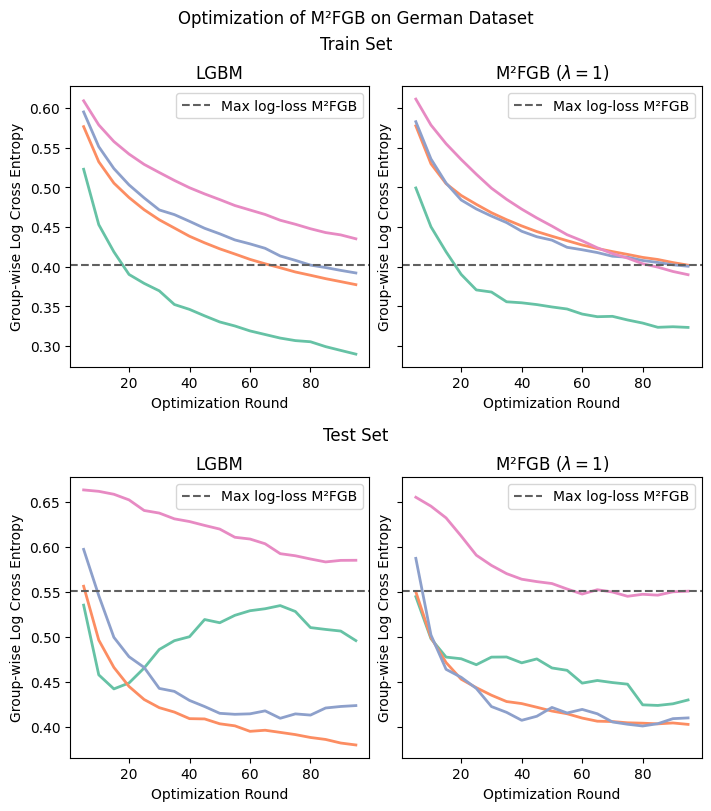

In [93]:
fig = plt.figure(constrained_layout=True, figsize = (7, 8))
fig.suptitle('Optimization of M²FGB on German Dataset')

subfigs = fig.subfigures(nrows=2, ncols=1)
sets = ["train", "test"]
set_names = ["Train Set", "Test Set"]
better_methods_names = {
    "lgbm" : "LGBM",
    "m2fgb" : "M²FGB ($\lambda = 1$)"
}
for row, subfig in enumerate(subfigs):
    subfig.suptitle(set_names[row])

    max_score = np.max(score[sets[row]]["m2fgb"][-1, :])
    axs = subfig.subplots(nrows=1, ncols=2, sharey=True)


    for col, ax in enumerate(axs):
        method = methods_names[col]

        ax.set_title(better_methods_names[method])

        # set color cycle to Pastel2
        ax.set_prop_cycle(color=plt.cm.Set2.colors)
        
        for ng in range(n_groups):
            ax.plot(iters_list, score[sets[row]][method][:, ng], lw = 2)


        ax.set_xlabel("Optimization Round")
        ax.set_ylabel("Group-wise Log Cross Entropy")

        ax.axhline(max_score, color = "#606060", linestyle = "--", label = "Max log-loss M²FGB")
        ax.legend()
        #ax.grid(True)

plt.savefig("../figs/convergence_german.pdf", dpi = 300)
plt.show()

## Remaining many tests

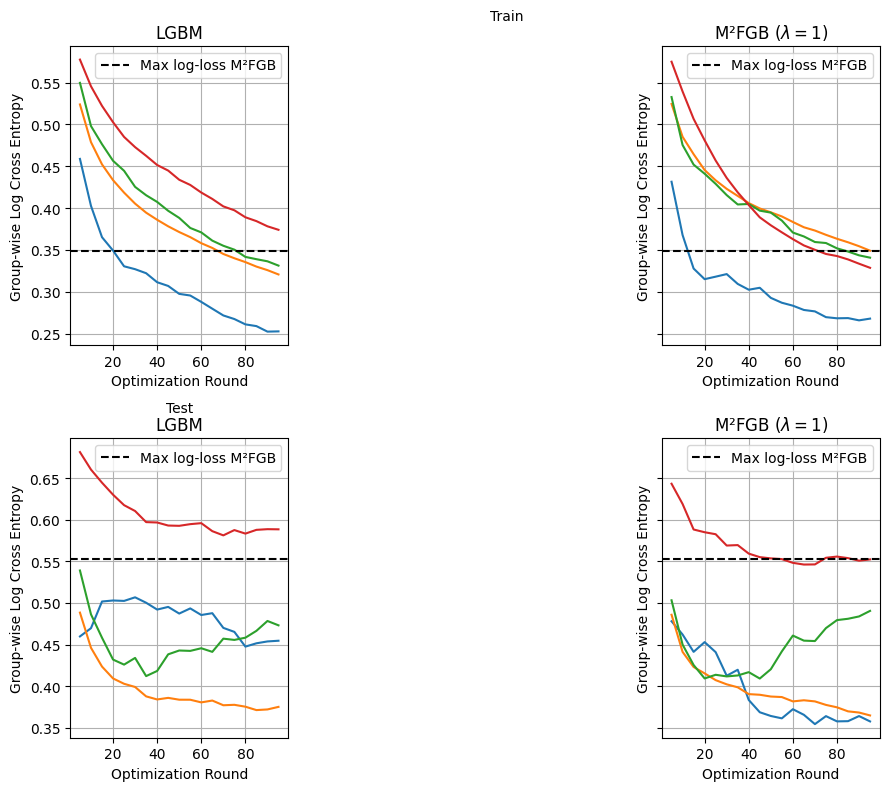

In [43]:
fig = plt.figure(constrained_layout=True)
fig.suptitle('Figure title')



fig, axs = plt.subplots(nrows = 2, ncols = len(methods_names), figsize = (9, 8), sharey = "row")



for i, method in enumerate(methods_names):
    for j, t in enumerate(["train", "test"]):
        # get max score of m2fgb
        max_score = np.max(score[t]["m2fgb"][-1, :])

        for ng in range(n_groups):
            axs[j, i].plot(iters_list, score[t][method][:, ng])

        axs[j, i].set_title(methods_names[method])
        axs[j, i].set_xlabel("Optimization Round")
        axs[j, i].set_ylabel("Group-wise Log Cross Entropy")

        axs[j, i].axhline(max_score, color = "black", linestyle = "--", label = "Max log-loss M²FGB")
        axs[j, i].legend()
        axs[j, i].grid(True)


plt.tight_layout()
#plt.savefig("convergence_analysis.pdf", dpi = 300)


In [10]:
dataset = "german"
n_folds = 10
fold = 0
SEED = 0
n_groups = 8

In [11]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = data.get_fold(
    dataset, fold, n_folds, SEED
)
A_train, A_val, A_test = experiments_new.get_subgroup_feature(
    dataset, X_train, X_val, X_test, n_groups
)
X_train, X_val, X_test = data.preprocess_dataset(dataset, X_train, X_val, X_test)

{'Female_4': 0, 'Male_2': 1, 'Male_1': 2, 'Male_3': 3, 'Male_4': 4, 'Female_2': 5, 'Female_1': 6, 'Female_3': 7}


In [ ]:
methods_names = ["lgbm", "m2fgb", "minmaxfair", "fairgbm"]
score = {}
score["train"] = dict([(m, []) for m in methods_names])
score["test"] = dict([(m, []) for m in methods_names])
computing_time = dict([(m, 0) for m in methods_names])

In [ ]:
for method in methods_names:
    for iter in iters_list:
        model = call_model(iter, method)
        start = time()
        model.fit(X_train, Y_train, A_train)
        end = time()

        computing_time[method] = end - start

        Y_pred = model.predict_proba(X_train)[:, 1]
        score["train"][method].append(utils.logloss_group(Y_train, Y_pred, A_train, "equalized_loss"))
        
        Y_pred = model.predict_proba(X_test)[:, 1]
        score["test"][method].append(utils.logloss_group(Y_test, Y_pred, A_test, "equalized_loss"))

    score["train"][method] = np.array(score["train"][method])
    score["test"][method] = np.array(score["test"][method])


In [ ]:
fig, axs = plt.subplots(nrows = 2, ncols = len(methods_names), figsize = (16, 8), sharey = "row")

for i, method in enumerate(methods_names):
    for j, t in enumerate(["train", "test"]):
        for ng in range(n_groups):
            axs[j, i].plot(iters_list, score[t][method][:, ng], label = f"group {ng}")

        axs[j, i].set_title(f"{method} {t} ({computing_time[method]:.2f}s)")
        axs[j, i].set_xlabel("Optimization Round")
        axs[j, i].set_ylabel("Group-wise Log Cross Entropy")

    plt.tight_layout()
    plt.savefig("convergence_analysis.pdf", dpi = 300)

In [ ]:
fig, axs = plt.subplots(nrows = 2, ncols = len(methods_names), figsize = (16, 8), sharey = "row")

for i, method in enumerate(methods_names):
    for j, t in enumerate(["train", "test"]):
        max_loss = np.max(score[t][method], axis = 1)

        axs[j, i].plot(iters_list, max_loss)

        sum_loss = np.sum(score[t][method], axis = 1)
        sum_loss -= max_loss
        mean_loss = sum_loss / (n_groups - 1)

        axs[j, i].plot(iters_list, mean_loss)


        axs[j, i].set_title(f"{method} {t} ({computing_time[method]:.2f}s)")


### Test with multiple folds

In [20]:
dataset = "acsincome"
n_folds = 10
n_groups = 8

params = {
    "learning_rate" : 0.1,
    "max_depth" : 6,
    "min_child_weight" : 5,
    "multiplier_learning_rate" : 0.02,
    "random_state" : SEED
}
call_m2fgb = lambda x : models.M2FGB(fair_weight = 1, dual_learning = "gradient_norm", n_estimators=x, **params)
call_lgbm = lambda x : models.M2FGB(fair_weight = 0, dual_learning = "gradient_norm", n_estimators=x, **params)


iters_list = [10, 30, 100, 500]

for fold in range(n_folds):

    X_train, Y_train, X_val, Y_val, X_test, Y_test = data.get_fold(
        dataset, fold, n_folds, SEED
    )
    A_train, A_val, A_test = experiments_new.get_subgroup_feature(
        dataset, X_train, X_val, X_test, n_groups
    )
    X_train, X_val, X_test = data.preprocess_dataset(dataset, X_train, X_val, X_test)

    methods_names = ["lgbm", "m2fgb"]
    score = {}
    score["train"] = dict([(m, []) for m in methods_names])
    score["test"] = dict([(m, []) for m in methods_names])
    computing_time = dict([(m, 0) for m in methods_names])


    for method in methods_names:
        for iter in iters_list:
            model = call_model(iter, method)
            start = time()
            model.fit(X_train, Y_train, A_train)
            end = time()

            print(iter)

            computing_time[method] = end - start

            Y_pred = model.predict_proba(X_train)[:, 1]
            score["train"][method].append(utils.logloss_group(Y_train, Y_pred, A_train, "equalized_loss"))
            
            Y_pred = model.predict_proba(X_test)[:, 1]
            score["test"][method].append(utils.logloss_group(Y_test, Y_pred, A_test, "equalized_loss"))

        score["train"][method] = np.array(score["train"][method])
        score["test"][method] = np.array(score["test"][method])
    break

{'1_male': 0, '1_female': 1, '4_male': 2, '3_male': 3, '2_female': 4, '3_female': 5, '2_male': 6, '4_female': 7}
10
30
100
500
10
30
100
500


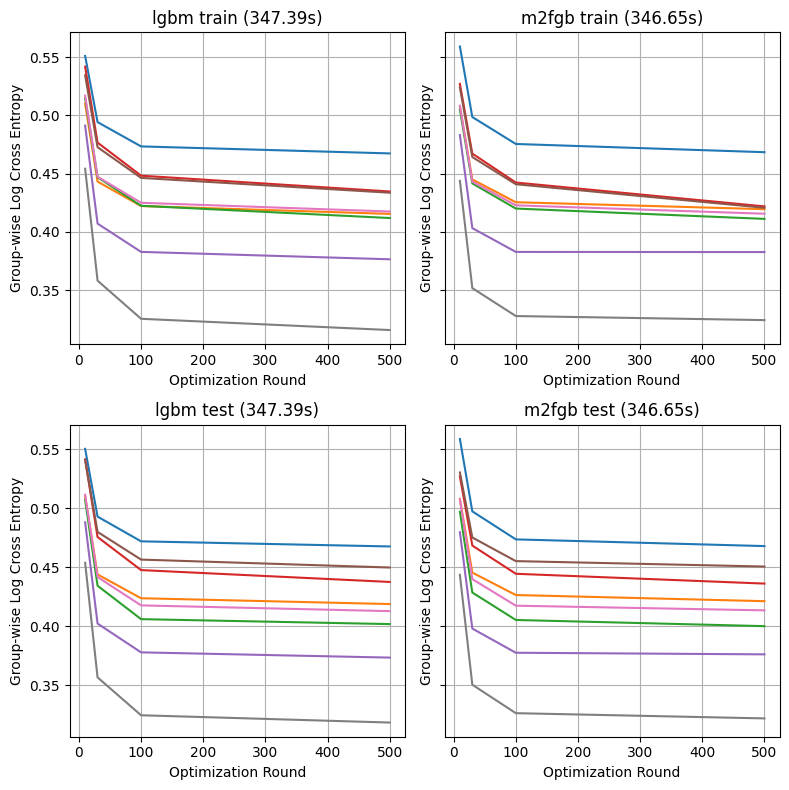

In [21]:
fig, axs = plt.subplots(nrows = 2, ncols = len(methods_names), figsize = (8, 8), sharey = "row")

for i, method in enumerate(methods_names):
    for j, t in enumerate(["train", "test"]):
        for ng in range(score[t][method].shape[1]):
            axs[j, i].plot(iters_list, score[t][method][:, ng], label = f"group {ng}")

        axs[j, i].set_title(f"{method} {t} ({computing_time[method]:.2f}s)")
        axs[j, i].set_xlabel("Optimization Round")
        axs[j, i].set_ylabel("Group-wise Log Cross Entropy")
        axs[j, i].grid(True)

plt.tight_layout()
plt.show()

In [47]:
m = models.M2FGB(fair_weight = 0, dual_learning="gradient_norm", n_estimators = 250, learning_rate = 0.05, multiplier_learning_rate=0.01)
m.fit(X_train, Y_train, A_train)

M2FGB(dual_learning='gradient_norm', fair_weight=0, learning_rate=0.05,
      multiplier_learning_rate=0.01, n_estimators=250)

In [71]:
m1 = models.M2FGB(fair_weight = 1, dual_learning="gradient_norm", n_estimators = 250, learning_rate = 0.05, multiplier_learning_rate=0.01, min_child_weight=5)
m1.fit(X_train, Y_train, A_train)

M2FGB(dual_learning='gradient_norm', fair_weight=1, learning_rate=0.05,
      min_child_weight=5, multiplier_learning_rate=0.01, n_estimators=250)

In [49]:
def plot_group_losses(m, ax = None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    ng = m.group_losses.shape[1]
    x = np.arange(m.group_losses.shape[0])
    for i in range(ng):
        ax.plot(x, m.group_losses[:, i], label = f"group {i}")

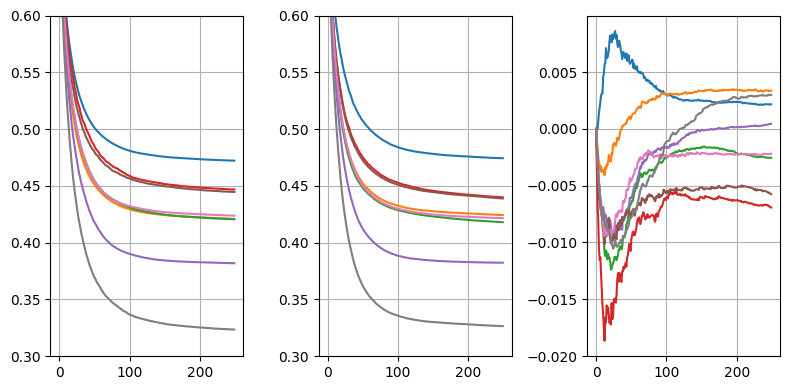

In [73]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (8, 4))
plot_group_losses(m, axs[0])
plot_group_losses(m1, axs[1])

for i in range(3):
    axs[i].grid(True)
    #axs[i].set_xlim([0, 100])

# make two first axes share the same y-axis
axs[0].set_ylim([0.3, 0.6])
axs[1].set_ylim([0.3, 0.6])

d = m1.group_losses - m.group_losses
for i in range(8):
    axs[2]  .plot(d[:, i])

plt.tight_layout()

In [66]:
m1 = models.M2FGB(fair_weight = 1, dual_learning="gradient_norm2", n_estimators = 250, learning_rate = 0.05, multiplier_learning_rate=0.01)
m1.fit(X_train, Y_train, A_train)

M2FGB(dual_learning='gradient_norm2', fair_weight=1, learning_rate=0.05,
      multiplier_learning_rate=0.01, n_estimators=250)

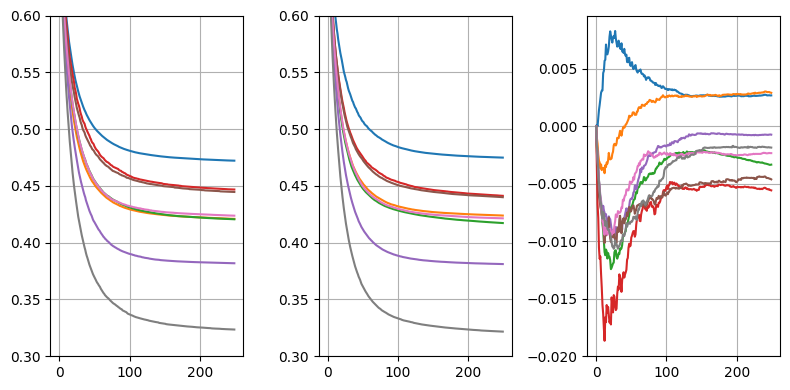

In [67]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (8, 4))
plot_group_losses(m, axs[0])
plot_group_losses(m1, axs[1])

for i in range(3):
    axs[i].grid(True)
    #axs[i].set_xlim([0, 100])

# make two first axes share the same y-axis
axs[0].set_ylim([0.3, 0.6])
axs[1].set_ylim([0.3, 0.6])

d = m1.group_losses - m.group_losses
for i in range(8):
    axs[2]  .plot(d[:, i])

plt.tight_layout()

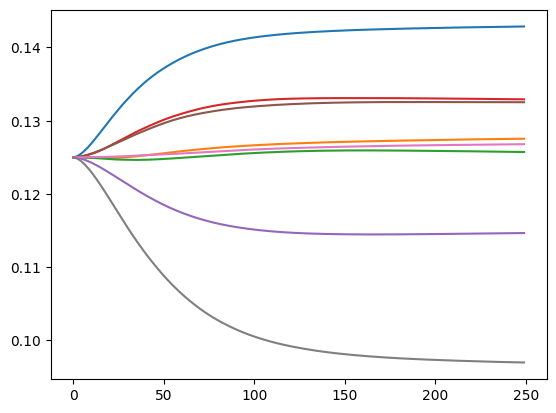

In [68]:
for i in range(8):
    plt.plot(m1.mu_opt_list[:, i])

In [69]:
m1 = models.M2FGB(fair_weight = 1, dual_learning="optim", n_estimators = 250, learning_rate = 0.05, multiplier_learning_rate=0.01)
m1.fit(X_train, Y_train, A_train)

M2FGB(fair_weight=1, learning_rate=0.05, multiplier_learning_rate=0.01,
      n_estimators=250)

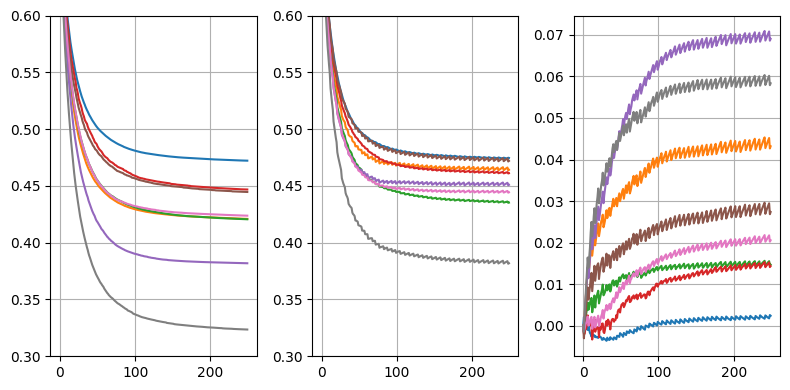

In [70]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (8, 4))
plot_group_losses(m, axs[0])
plot_group_losses(m1, axs[1])

for i in range(3):
    axs[i].grid(True)
    #axs[i].set_xlim([0, 100])

# make two first axes share the same y-axis
axs[0].set_ylim([0.3, 0.6])
axs[1].set_ylim([0.3, 0.6])

d = m1.group_losses - m.group_losses
for i in range(8):
    axs[2]  .plot(d[:, i])

plt.tight_layout()

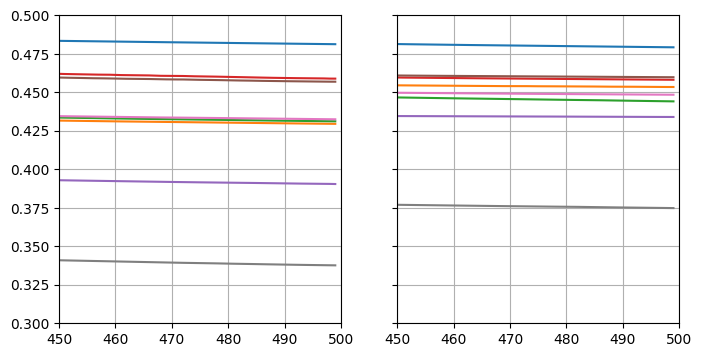

In [44]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, sharey = True, figsize = (8, 4))
plot_group_losses(m, axs[0])
plot_group_losses(m1, axs[1])

for i in range(2):
    axs[i].grid(True)
    axs[i].set_xlim([450, 500])
    axs[i].set_ylim([0.3, 0.5])

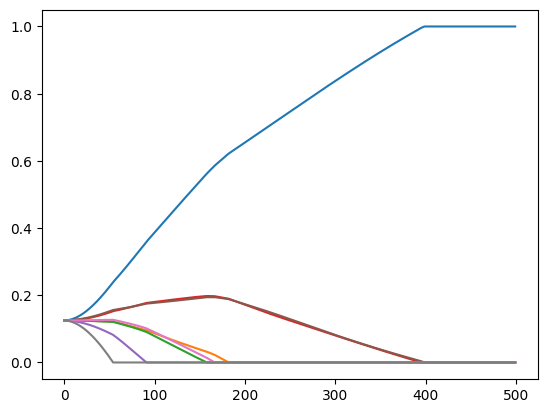

In [41]:
for i in range(8):
    plt.plot(m1.mu_opt_list[:, i])

### ACSIncome

In [71]:
iters_list = list(range(5, 30, 3))
call_m2fgb = lambda x : models.M2FGB(fair_weight= 0.9, multiplier_learning_rate = 0.05, learning_rate=0.1, dual_learning = "gradient_norm", n_estimators=x, random_state= SEED)
call_lgbm = lambda x : models.LGBMClassifier(n_estimators = x, random_state = SEED)
call_fairgbm = lambda x : models.M2FGB(n_estimators = x, random_state = SEED)
call_minmaxfair = lambda x : models.MinMaxFair(n_estimators = x, gamma = 0.5, max_iter=10)

def call_model(x, model_name):
    if model_name == "m2fgb":
        return call_m2fgb(x)
    elif model_name == "lgbm":
        return call_lgbm(x)
    elif model_name == "fairgbm":
        return call_fairgbm(x)
    elif model_name == "minmaxfair":
        return call_minmaxfair(x)

### 4 groups

In [72]:
dataset = "acsincome"
n_folds = 10
fold = 0
n_groups = 4

In [73]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = data.get_fold(
    dataset, fold, n_folds, SEED
)
A_train, A_val, A_test = experiments_new.get_subgroup_feature(
    dataset, X_train, X_val, X_test, n_groups
)
X_train, X_val, X_test = data.preprocess_dataset(dataset, X_train, X_val, X_test)

{'1': 0, '4': 1, '3': 2, '2': 3}


In [74]:
methods_names = ["lgbm", "m2fgb"]#, "minmaxfair", "fairgbm"]
score = {}
score["train"] = dict([(m, []) for m in methods_names])
score["test"] = dict([(m, []) for m in methods_names])
computing_time = dict([(m, 0) for m in methods_names])

In [75]:
iters_list = [5, 100, 1000]

In [76]:
for method in methods_names:
    for iter in iters_list:
        model = call_model(iter, method)
        start = time()
        model.fit(X_train, Y_train, A_train)
        end = time()

        print(iter)

        computing_time[method] = end - start

        Y_pred = model.predict_proba(X_train)[:, 1]
        score["train"][method].append(utils.logloss_group(Y_train, Y_pred, A_train, "equalized_loss"))
        
        Y_pred = model.predict_proba(X_test)[:, 1]
        score["test"][method].append(utils.logloss_group(Y_test, Y_pred, A_test, "equalized_loss"))

    score["train"][method] = np.array(score["train"][method])
    score["test"][method] = np.array(score["test"][method])


5
100
1000
5
100
1000


In [77]:
score

{'train': {'lgbm': array([[0.56605082, 0.49322904, 0.58005116, 0.50881721],
         [0.44680129, 0.37546126, 0.44443025, 0.40207004],
         [0.43897681, 0.35440374, 0.42507726, 0.38705286]]),
  'm2fgb': array([[0.58382414, 0.54610055, 0.57608733, 0.5585113 ],
         [0.45144273, 0.37795507, 0.44157644, 0.40159728],
         [0.44000925, 0.37151437, 0.41657984, 0.398875  ]])},
 'test': {'lgbm': array([[0.56605721, 0.48890419, 0.5827618 , 0.50629142],
         [0.44678422, 0.36555695, 0.4496457 , 0.39521015],
         [0.44416835, 0.36260415, 0.44251455, 0.3910761 ]]),
  'm2fgb': array([[0.58376374, 0.54331677, 0.5778721 , 0.55738999],
         [0.45092956, 0.36856814, 0.44998974, 0.39690798],
         [0.44408084, 0.36316136, 0.44143298, 0.39395435]])}}

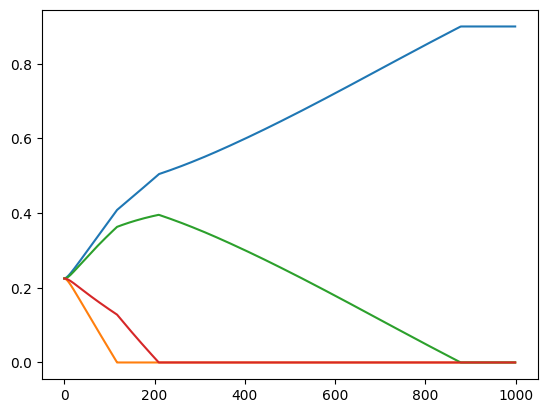

In [78]:
for i in range(n_groups):
    plt.plot(model.mu_opt_list[:, i])

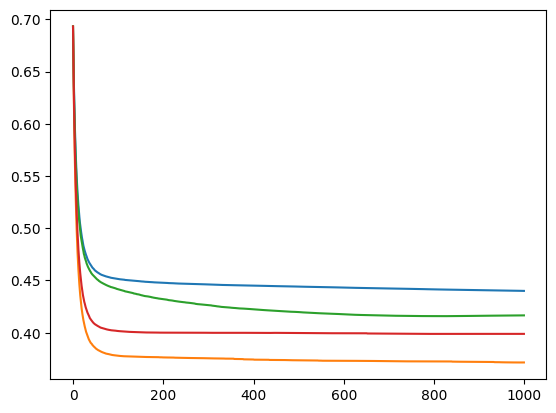

In [86]:
for i in range(n_groups):
    plt.plot(model.group_losses[:, i])

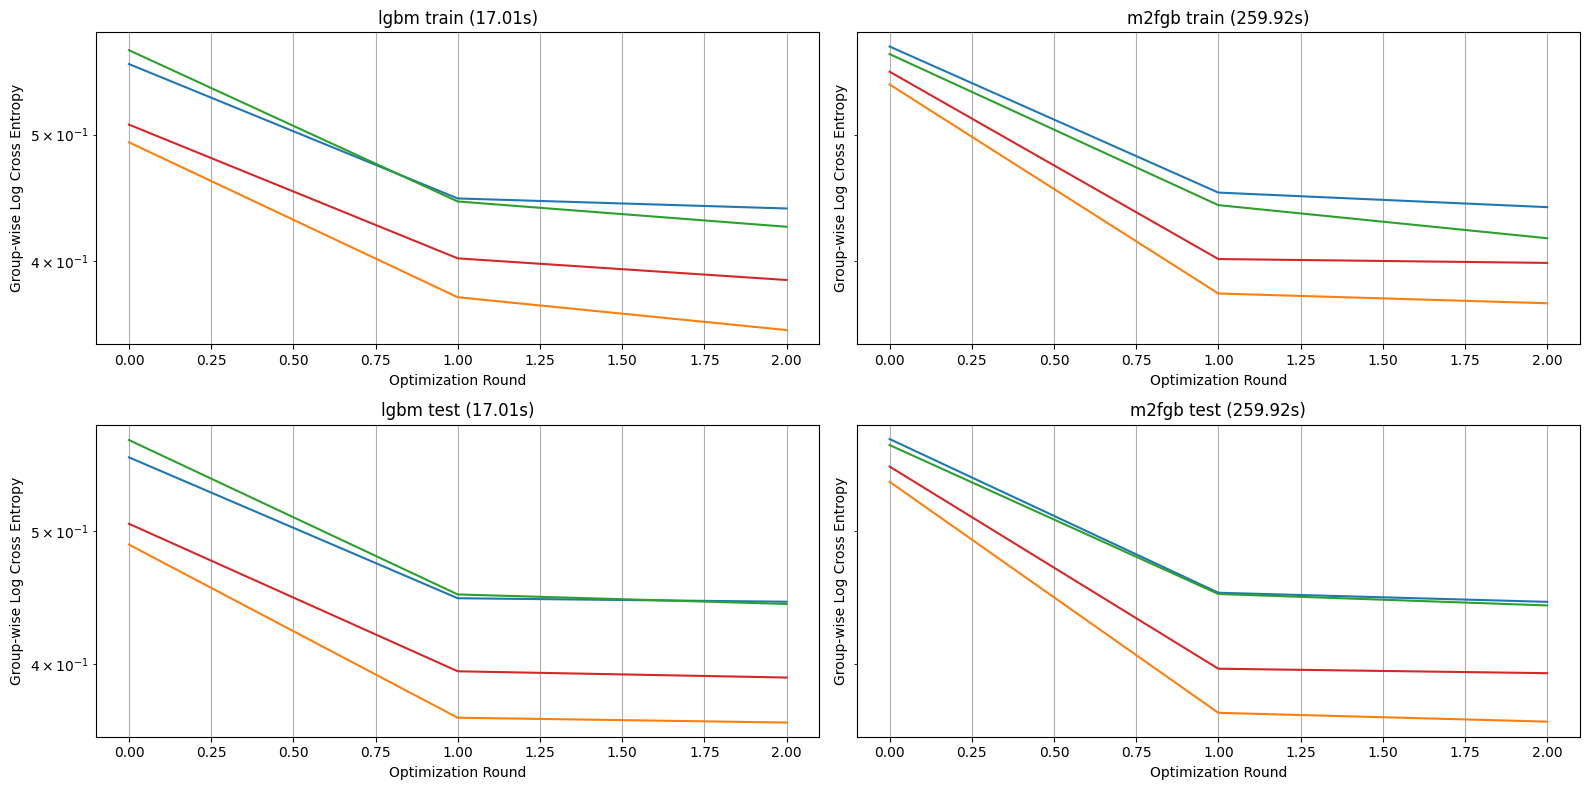

In [81]:
fig, axs = plt.subplots(nrows = 2, ncols = len(methods_names), figsize = (16, 8), sharey = "row")

for i, method in enumerate(methods_names):
    for j, t in enumerate(["train", "test"]):
        for ng in range(n_groups):
            axs[j, i].plot(list(range(3)), score[t][method][:, ng], label = f"group {ng}")

        axs[j, i].set_title(f"{method} {t} ({computing_time[method]:.2f}s)")
        axs[j, i].set_xlabel("Optimization Round")
        axs[j, i].set_ylabel("Group-wise Log Cross Entropy")
        axs[j, i].set_yscale("log")
        axs[j, i].grid(True)

    plt.tight_layout()
    #plt.savefig("convergence_analysis.pdf", dpi = 300)
